In [20]:
# Load packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import json

In [21]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [30]:
# load the small datasets, which are json files
amazon_fashion = getDF('AMAZON_FASHION_5.json.gz')
all_beauty = getDF('All_Beauty_5.json.gz')
magazine_subscriptions = getDF('Magazine_Subscriptions_5.json.gz')
luxury_beauty = getDF('Luxury_Beauty_5.json.gz')

print(f"Shape of the amazon data is: {amazon_fashion.shape}")
print(f"Shape of the data is: {all_beauty.shape}")
print(f"Shape of the data is: {magazine_subscriptions.shape}")
print(f"Shape of the luxury beauty data is: {luxury_beauty.shape}")

Shape of the amazon data is: (3176, 12)
Shape of the data is: (5269, 12)
Shape of the data is: (2375, 12)
Shape of the luxury beauty data is: (34278, 12)


In [31]:
print(amazon_fashion.head())

   overall  verified  reviewTime     reviewerID        asin  \
0      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
1      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
2      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
3      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
4      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   

                                               style reviewerName  \
0   {'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}     Tonya B.   
1  {'Size:': ' Big Boys', 'Color:': ' Black (3746...     Tonya B.   
2  {'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...     Tonya B.   
3  {'Size:': ' Big Boys', 'Color:': ' Blue (37867...     Tonya B.   
4     {'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}     Tonya B.   

                 reviewText     summary  unixReviewTime vote image  
0  Great product and price!  Five Stars      1441324800  NaN   NaN  
1  Great product and price!  Five Stars      1441324800  NaN   NaN  

In [32]:
def merge_ratings(df):
    """
    Merges ratings 1 and 2 into 1, and shifts 3, 4, 5 to 2, 3, 4 respectively.

    Args:
    df (pd.DataFrame): The dataframe containing the ratings.
    rating_column (str): The name of the column with the ratings.

    Returns:
    pd.DataFrame: The modified dataframe with updated ratings.
    """
    # Replace ratings
    df.overall = df.overall.replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 4})

    # Update categories if the column is categorical
    if pd.api.types.is_categorical_dtype(df.overall):
        df.overall = df.overall.cat.set_categories([1, 2, 3, 4])

    # remove the revies that have empty text
    df = df[~df.reviewText.isna()]
# remove the reviews that are not verified purchases
    df = df[df.verified == True]

    return df

In [33]:
amazon_fashion = merge_ratings(amazon_fashion)
all_beauty = merge_ratings(all_beauty)
magazine_subscriptions = merge_ratings(magazine_subscriptions)
luxury_beauty = merge_ratings(luxury_beauty)

/var/folders/fr/hhmn4_v95y5gvr62ng6hskj40000gn/T/ipykernel_10547/3180239337.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df.overall):


In [34]:
luxury_beauty.to_csv('luxury_beauty.csv', index=False)

/Users/stinegregersen/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


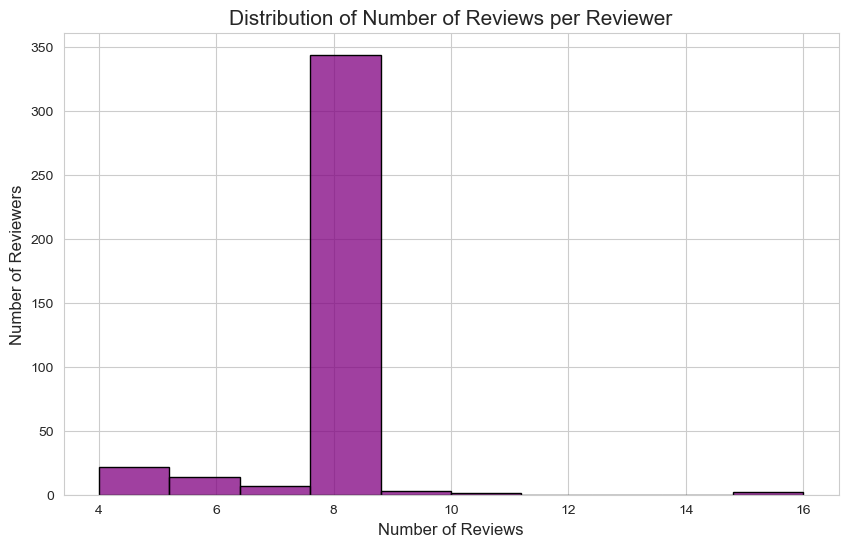

In [8]:
# plot the distribution of the how many reviews each reviewer has written
# Assuming 'data.reviewerID' contains the reviewerID
reviewers = magazine_subscriptions.reviewerID.value_counts()
reviewers = all_beauty.reviewerID.value_counts()
reviewers = amazon_fashion.reviewerID.value_counts()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(reviewers, kde=False, color='purple', edgecolor='black')

# Adding titles and labels
plt.title('Distribution of Number of Reviews per Reviewer', fontsize=15)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Reviewers', fontsize=12)

# Show the plot
plt.show()

In [9]:
def merge_datasets_with_equal_distribution(df1, df2, df3):
    """
    Merges three datasets ensuring equal distribution of ratings and equal amount from each set.

    Args:
    df1, df2, df3 (pd.DataFrame): The three dataframes to be merged.
    rating_column (str): The name of the column with the ratings.

    Returns:
    pd.DataFrame: The merged dataframe with equal distribution.
    """
    # Add a category column to each dataframe
    df1['category'] = 'amazon_fashion'
    df2['category'] = 'all_beauty'
    df3['category'] = 'magazine_subscriptions'

    # Find minimum count of each rating across all datasets
    min_counts = pd.concat([df1, df2, df3]).groupby('overall').size().min()
    print(f"minimum number of reviews in a category", min_counts)
    # Sample each dataframe to have equal distribution of ratings
    dfs_equal = []
    for df in [df1, df2, df3]:
        df_sampled = df.groupby('overall').sample(n=min_counts, replace=True)
        dfs_equal.append(df_sampled)

    # Concatenate the dataframes
    merged_df = pd.concat(dfs_equal)

    return merged_df

In [17]:
data = merge_datasets_with_equal_distribution(amazon_fashion, all_beauty, magazine_subscriptions)
print(f"shape of the data is now: {data.shape}")

data.head()


minimum number of reviews in a category 477
shape of the data is now: (5724, 13)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,category
1442,1.0,True,"03 25, 2017",A2K5ZBX75J80TX,B009MA34NY,"{'Size:': ' 9 W US', 'Color:': ' Cool Grey / V...",Marjorie A. Dunbar,Ordered 9(m) received 9 Wide for the second ti...,One Star,1490400000,NaN,NaN,amazon_fashion
2688,1.0,True,"09 11, 2016",A3SM5XENOINDNH,B010RRWKT4,"{'Size:': ' 7.5 B(M) US', 'Color:': ' Black/Wh...",Marielys Rodrguez,After using this shoes seven times for regular...,Poor Quality. Don't buy.,1473552000,14,[https://images-na.ssl-images-amazon.com/image...,amazon_fashion
148,1.0,True,"05 21, 2015",A36GNVEQP92OPA,B0017LGD34,NaN,Peter B. Thorp,I'm not sure I was shipped the correct style. ...,Huh,1432166400,NaN,NaN,amazon_fashion
103,1.0,True,"02 21, 2017",ABX2R8Q6GBTJ8,B000YFSR5G,"{'Size:': ' Medium', 'Color:': ' Black'}",Sammy C.,Nice pants but too small for a medium. Return it.,Returned also,1487635200,NaN,NaN,amazon_fashion
1506,1.0,True,"12 15, 2016",A3PTZ7IHGU9BA8,B009MA34NY,"{'Size:': ' 7 B(M) US', 'Color:': ' Black/Red ...",Amazon Customer,wrong shoes,One Star,1481760000,NaN,NaN,amazon_fashion


In [18]:
print(data.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'category'],
      dtype='object')


In [19]:
# Save data
data.to_csv('complete_data.csv', index=False)

/Users/stinegregersen/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


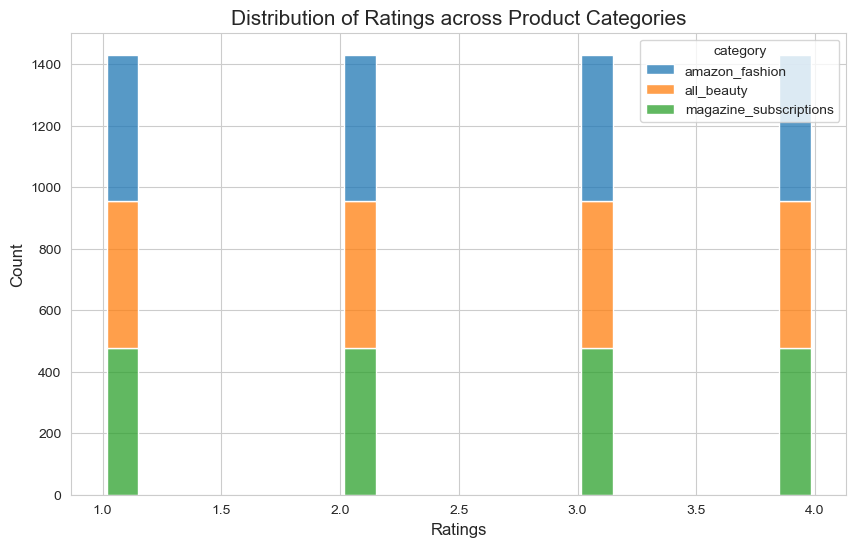

In [12]:
# print the distribution to make sure we have an equal emount of each
# Examine the distribution of ratings across different product categories

# plot the histogram of the ratings for each category of products
plt.figure(figsize=(10, 6))
sns.histplot(data, x='overall', hue='category', multiple='stack', shrink=.8)

# Adding titles and labels
plt.title('Distribution of Ratings across Product Categories', fontsize=15)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()


need too check that not all reviews come from the same person..

In [13]:
print(f"Number of unique reviewers in the dataset: {len(data.reviewerID.unique())}")
print(f"the number of reviews are {len(data.reviewerID)}")

Number of unique reviewers in the dataset: 1052
the number of reviews are 5724


                                               count
reviewerID     category               overall       
A105A034ZG9EHO all_beauty             4.0          2
A10BWUA2MGA9BK magazine_subscriptions 3.0          6
                                      4.0          1
A10JB7YPWZGRF4 all_beauty             4.0          1
A10RXRZE0TAKPU amazon_fashion         3.0          7
...                                              ...
AZFYUPGEE6KLW  all_beauty             4.0          1
AZRD4IZU6TBFV  all_beauty             4.0          1
AZRZ2FB7CFNOE  amazon_fashion         4.0          3
AZUK3G0CKWJZ1  magazine_subscriptions 3.0          2
AZYHPRWLMSY9O  amazon_fashion         4.0          1

[1234 rows x 1 columns]


/Users/stinegregersen/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


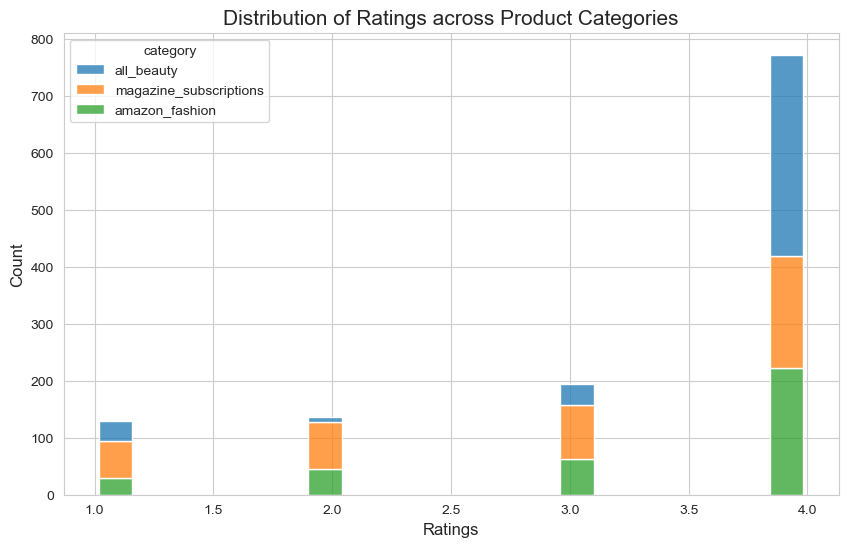

In [14]:
unique_reviewers = data.groupby(["reviewerID", "category", "overall"]).overall.agg(['count'])
unique_reviewers.drop_duplicates

print(unique_reviewers)

# plot the histogram of the ratings for each category of products
plt.figure(figsize=(10, 6))
sns.histplot(unique_reviewers, x='overall', hue='category', multiple='stack', shrink=.8)

# Adding titles and labels
plt.title('Distribution of Ratings across Product Categories', fontsize=15)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

quit a few individuals are the same in the low ratings. 

should we add one more category? or maybe load the bigger datasets?

could test with and without stopwords. 

and only keeping these categories and adding more diversity?



In [15]:
unique_reviewers.sort_values('count',ascending=False).head(20)

,,,count
reviewerID,category,overall,
A3T2BPXBDMLJPE,all_beauty,2.0,72
A1AN9A2FNOYHTX,all_beauty,2.0,71
AKJHHD5VEH7VG,all_beauty,2.0,70
AIPW346SC1MMK,all_beauty,2.0,68
ARPSCXPD7FYZ4,all_beauty,2.0,60
A1CEDYAX0NG4BU,all_beauty,2.0,57
A1F4BVHEE78OVF,all_beauty,2.0,31
A1WTD80C8J0QE2,magazine_subscriptions,1.0,30
A3PTZ7IHGU9BA8,amazon_fashion,1.0,27


                                                                                   count
reviewText                                         category               overall       
"Inc Magazine" is a highly inspirational magazi... magazine_subscriptions 4.0          1
"The Cosmo Sex Poll - 6,000 Horny Guys Tell All... magazine_subscriptions 1.0          4
"Vogue" magazine  is an interesting publication... magazine_subscriptions 4.0          2
$65 for one bottles of soap!! Do NOT use this s... all_beauty             4.0          1
(Forgive me if this looks like another of my re... magazine_subscriptions 2.0          8
...                                                                                  ...
works great                                        all_beauty             4.0          2
wrong shoes                                        amazon_fashion         1.0         27
yes                                                amazon_fashion         4.0          1
yum                  

/Users/stinegregersen/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


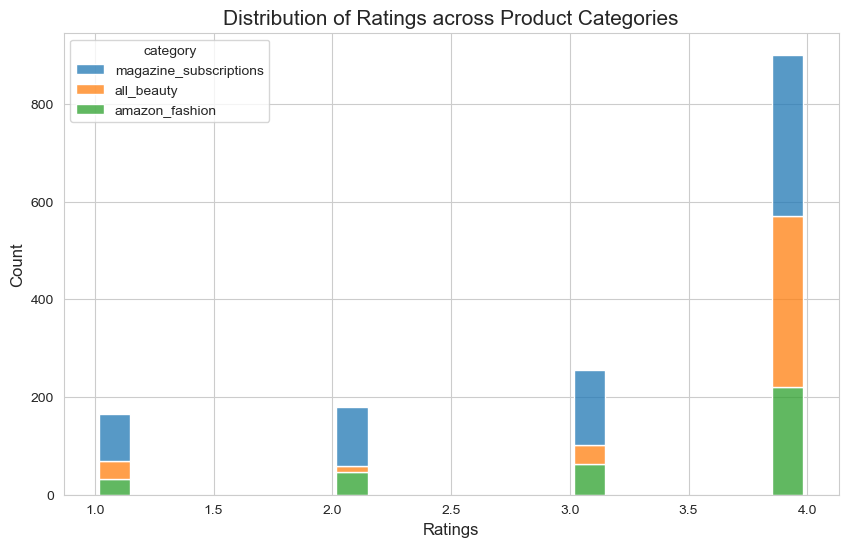

In [16]:
# unique reviews text per category
unique_reviews = data.groupby(["reviewText", "category", "overall"]).overall.agg(['count'])
unique_reviews.drop_duplicates
print(unique_reviews)

# plot the histogram of the ratings for each category of products
plt.figure(figsize=(10, 6))
sns.histplot(unique_reviews, x='overall', hue='category', multiple='stack', shrink=.8)

# Adding titles and labels
plt.title('Distribution of Ratings across Product Categories', fontsize=15)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()